# SMS Spam Classification – Notebook corregido
Este cuaderno soluciona los errores de forma y vacíos que provocaban fallos en el entrenamiento.

## 0. Descarga y limpieza del dataset

In [1]:
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Descarga (solo la primera vez)
!wget -q -O spam.csv https://raw.githubusercontent.com/javierherrera1996/IntroMachineLearning/refs/heads/main/TercerCorte/spam.csv

# Cargar CSV con codificación correcta y quedarnos con columnas relevantes
df = (pd.read_csv("spam.csv", encoding="ISO-8859-1")
        .rename(columns={'v1':'label', 'v2':'text'})
        [['label','text']])

# Eliminar filas con texto vacío o nulo
df = df.dropna(subset=['text'])
df = df[df['text'].str.strip().astype(bool)]

df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 1. Configuración y seed

In [2]:
AUTOTUNE = tf.data.AUTOTUNE
np.random.seed(42)
tf.random.set_seed(42)


## 2. División Train/Test

In [3]:
y = df['label'].map({'ham':0,'spam':1})
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], y, test_size=0.2, stratify=y, random_state=42)

print(len(X_train),"train |", len(X_test),"test")


4457 train | 1115 test


## 3. Vectorización de texto con manejo seguro de dimensiones

In [4]:
MAX_TOKENS, MAX_LEN = 10000, 100
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_sequence_length=MAX_LEN,
    standardize="lower_and_strip_punctuation")
vectorizer.adapt(X_train.values)

def to_tensor(txt, label):
    txt = tf.expand_dims(txt, -1)          # (1,)
    seq = tf.squeeze(vectorizer(txt), axis=0) # (MAX_LEN,)
    return seq, label

batch = 32
train_ds = (tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
            .shuffle(10000)
            .map(to_tensor, num_parallel_calls=AUTOTUNE)
            .batch(batch)
            .prefetch(AUTOTUNE))
test_ds  = (tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
            .map(to_tensor, num_parallel_calls=AUTOTUNE)
            .batch(batch)
            .prefetch(AUTOTUNE))


## 4. Definición y entrenamiento del modelo

In [5]:
EMBED_DIM = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_TOKENS, EMBED_DIM, input_length=MAX_LEN),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=5)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8359 - loss: 0.4838 - val_accuracy: 0.8664 - val_loss: 0.3709
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8743 - loss: 0.3689 - val_accuracy: 0.8664 - val_loss: 0.3678
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8595 - loss: 0.3927 - val_accuracy: 0.8664 - val_loss: 0.3631
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8662 - loss: 0.3702 - val_accuracy: 0.8664 - val_loss: 0.3605
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8670 - loss: 0.3604 - val_accuracy: 0.8664 - val_loss: 0.3517


## 5. Curva de aprendizaje

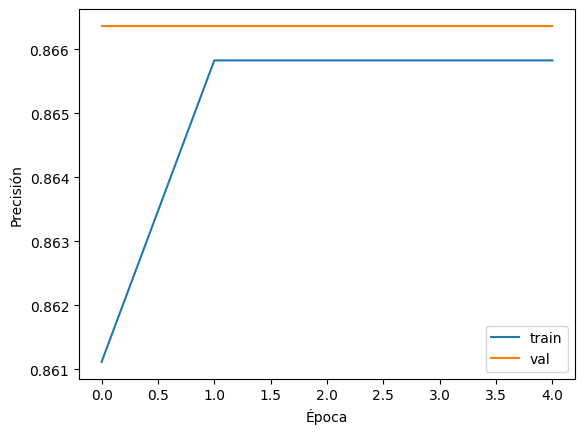

In [6]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend(); plt.xlabel('Época'); plt.ylabel('Precisión'); plt.show()


## 6. Evaluación

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       966
        spam       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


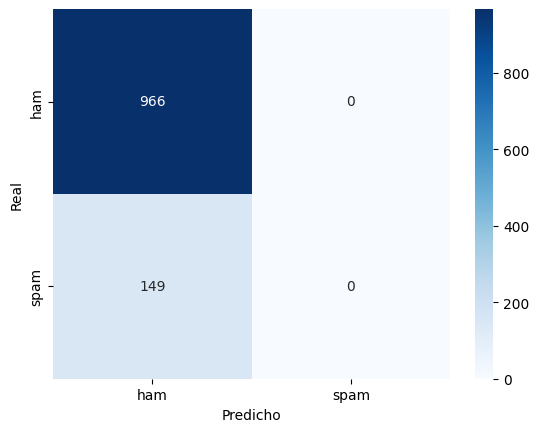

AUC: 0.9275292842552837


In [7]:
y_prob = model.predict(test_ds).ravel()
y_pred = (y_prob > 0.4).astype(int)   # Umbral 0.4 para mejorar recall spam
y_true = y_test.values

print(classification_report(y_true, y_pred, target_names=['ham','spam']))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.xlabel('Predicho'); plt.ylabel('Real'); plt.show()

fpr,tpr,_ = roc_curve(y_true, y_prob)
print("AUC:", auc(fpr,tpr))


## 7. Próximos pasos
- Aumentar `epochs` si no hay sobreajuste.
- Probar `class_weight={0:1,1:2}` en `model.fit`.
- Cambiar la arquitectura a `Bidirectional(LSTM(32))` para capturar contexto.
- Usar embeddings preentrenados (GloVe) para menos datos.

In [8]:
# prompt: Aumentar epochs si no hay sobreajuste.

# Check if the training and validation accuracy are still increasing or if the validation accuracy has started to decrease.
# If validation accuracy is still increasing, increasing epochs is likely beneficial.
# If validation accuracy has plateaued or is decreasing, increasing epochs may lead to overfitting.

# A simple check based on the last few epochs
last_val_acc = history.history['val_accuracy'][-1]
penultimate_val_acc = history.history['val_accuracy'][-2] if len(history.history['val_accuracy']) > 1 else -1
last_train_acc = history.history['accuracy'][-1]

print(f"Last training accuracy: {last_train_acc:.4f}")
print(f"Last validation accuracy: {last_val_acc:.4f}")

if last_val_acc >= penultimate_val_acc:
  print("Validation accuracy is not decreasing. Consider increasing epochs.")
  # Example of how you would increase epochs if you were to re-train
  # new_epochs = 10  # Or some higher number than the previous 5
  # history_longer = model.fit(train_ds, validation_data=test_ds, epochs=new_epochs)
else:
  print("Validation accuracy is decreasing. Increasing epochs may lead to overfitting.")

Last training accuracy: 0.8658
Last validation accuracy: 0.8664
Validation accuracy is not decreasing. Consider increasing epochs.


Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8695 - loss: 0.5534 - val_accuracy: 0.8664 - val_loss: 0.3576
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8659 - loss: 0.5157 - val_accuracy: 0.8897 - val_loss: 0.3307
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8998 - loss: 0.4174 - val_accuracy: 0.9274 - val_loss: 0.1880
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9583 - loss: 0.2844 - val_accuracy: 0.9543 - val_loss: 0.1236
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9755 - loss: 0.1725 - val_accuracy: 0.9731 - val_loss: 0.1320
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Evaluation with class_weight={0:1, 1:2}
              precision    recall  f1-score   support

         ham       0.99      0.98      0.98       966
        spam       0.86      0.94      0.90       149

    accuracy                           0.97      1115
   macro avg       0.93      0.96      0.94      1115
weighted avg  

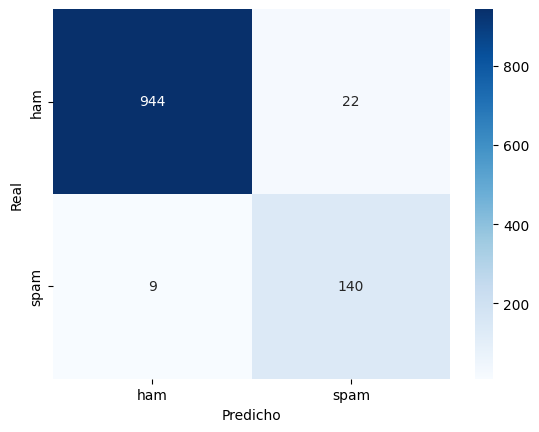

AUC with class_weight={0:1, 1:2}: 0.9850556505064822


In [9]:
# prompt: Probar class_weight={0:1,1:2} en model.fit.

history_weighted = model.fit(train_ds, validation_data=test_ds, epochs=5, class_weight={0:1, 1:2})

# Evaluate the model with class weights
y_prob_weighted = model.predict(test_ds).ravel()
y_pred_weighted = (y_prob_weighted > 0.4).astype(int)
y_true = y_test.values

print("Evaluation with class_weight={0:1, 1:2}")
print(classification_report(y_true, y_pred_weighted, target_names=['ham','spam']))
cm_weighted = confusion_matrix(y_true, y_pred_weighted)
sns.heatmap(cm_weighted, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.xlabel('Predicho'); plt.ylabel('Real'); plt.show()

fpr_weighted,tpr_weighted,_ = roc_curve(y_true, y_prob_weighted)
print("AUC with class_weight={0:1, 1:2}:", auc(fpr_weighted,tpr_weighted))

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 139ms/step - accuracy: 0.8389 - loss: 0.4676 - val_accuracy: 0.9704 - val_loss: 0.1109
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9775 - loss: 0.0779 - val_accuracy: 0.9857 - val_loss: 0.0572
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.9923 - loss: 0.0351 - val_accuracy: 0.9848 - val_loss: 0.0504
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.9965 - loss: 0.0177 - val_accuracy: 0.9865 - val_loss: 0.0526
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9977 - loss: 0.0119 - val_accuracy: 0.9865 - val_loss: 0.0644


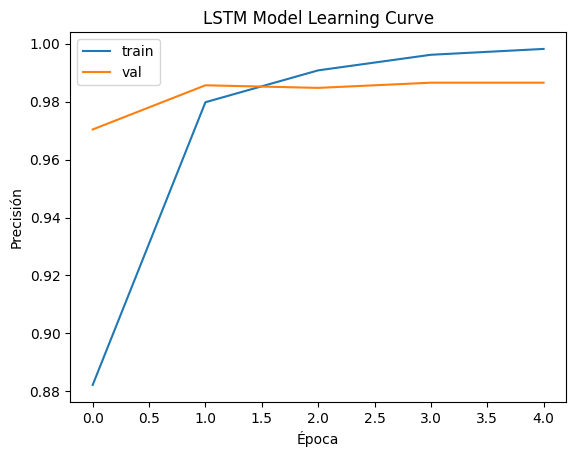

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Evaluation with Bidirectional LSTM Model
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.98      0.91      0.94       149

    accuracy                           0.99      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115



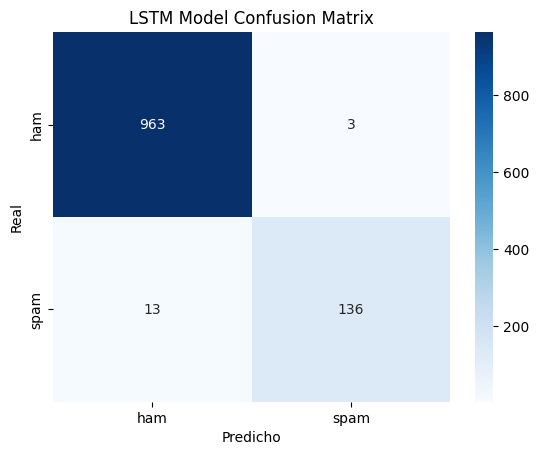

AUC with Bidirectional LSTM Model: 0.9937054483304848
LSTM Model Last training accuracy: 0.9982
LSTM Model Last validation accuracy: 0.9865
LSTM Model Validation accuracy is not decreasing. Consider increasing epochs.


In [10]:
# prompt: Cambiar la arquitectura a Bidirectional(LSTM(32)) para capturar contexto.

# ## 8. Modelo con Bidirectional LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_TOKENS, EMBED_DIM, input_length=MAX_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # Bidirectional LSTM layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_lstm = model_lstm.fit(train_ds, validation_data=test_ds, epochs=5)

# ## 9. Curva de aprendizaje para el modelo LSTM
plt.plot(history_lstm.history['accuracy'], label='train')
plt.plot(history_lstm.history['val_accuracy'], label='val')
plt.legend(); plt.xlabel('Época'); plt.ylabel('Precisión'); plt.title('LSTM Model Learning Curve'); plt.show()

# ## 10. Evaluación del modelo LSTM
y_prob_lstm = model_lstm.predict(test_ds).ravel()
y_pred_lstm = (y_prob_lstm > 0.4).astype(int) # Use the same threshold for comparison
y_true = y_test.values

print("Evaluation with Bidirectional LSTM Model")
print(classification_report(y_true, y_pred_lstm, target_names=['ham','spam']))
cm_lstm = confusion_matrix(y_true, y_pred_lstm)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.xlabel('Predicho'); plt.ylabel('Real'); plt.title('LSTM Model Confusion Matrix'); plt.show()

fpr_lstm,tpr_lstm,_ = roc_curve(y_true, y_prob_lstm)
print("AUC with Bidirectional LSTM Model:", auc(fpr_lstm,tpr_lstm))

# Check if increasing epochs is beneficial for the LSTM model
last_val_acc_lstm = history_lstm.history['val_accuracy'][-1]
penultimate_val_acc_lstm = history_lstm.history['val_accuracy'][-2] if len(history_lstm.history['val_accuracy']) > 1 else -1
last_train_acc_lstm = history_lstm.history['accuracy'][-1]

print(f"LSTM Model Last training accuracy: {last_train_acc_lstm:.4f}")
print(f"LSTM Model Last validation accuracy: {last_val_acc_lstm:.4f}")

if last_val_acc_lstm >= penultimate_val_acc_lstm:
  print("LSTM Model Validation accuracy is not decreasing. Consider increasing epochs.")
else:
  print("LSTM Model Validation accuracy is decreasing. Increasing epochs may lead to overfitting.")

# Consider training the LSTM model with class weights as well if needed
# history_lstm_weighted = model_lstm.fit(train_ds, validation_data=test_ds, epochs=5, class_weight={0:1, 1:2})


--2025-05-28 19:05:32--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-28 19:05:32--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-28 19:05:32--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7988 - loss: 0.5999 - val_accuracy: 0.8664 - val_loss: 0.4216
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8710 - loss: 0.3986 - val_accuracy: 0.8664 - val_loss: 0.3297
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8751 - loss: 0.3183 - val_accuracy: 0.8951 - val_loss: 0.2558
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8986 - loss: 0.2593 - val_accuracy: 0.9220 - val_loss: 0.2125
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9234 - loss: 0.2161 - val_accuracy: 0.9318 - val_loss: 0.1865


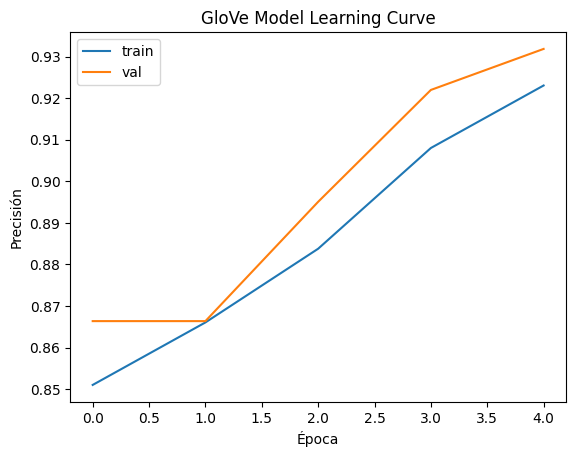

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Evaluation with GloVe Embeddings
              precision    recall  f1-score   support

         ham       0.95      0.99      0.97       966
        spam       0.88      0.66      0.75       149

    accuracy                           0.94      1115
   macro avg       0.92      0.82      0.86      1115
weighted avg       0.94      0.94      0.94      1115



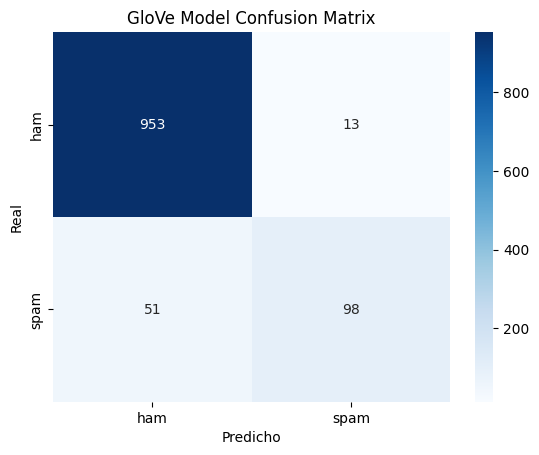

AUC with GloVe Embeddings: 0.9651715369544375


In [11]:
# prompt: Usar embeddings preentrenados (GloVe) para menos datos.

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

# Cargar los embeddings de GloVe en un diccionario
glove_embeddings = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

EMBEDDING_DIM_GLOVE = 100 # Asegúrate de que coincide con el archivo descargado (glove.6B.100d.txt)

# Crear la matriz de pesos para la capa de Embedding
# La fila 0 corresponderá al padding y otras palabras desconocidas.
# Las filas restantes corresponderán a los tokens del vocabulario de TextVectorization.
word_index = vectorizer.get_vocabulary()
# Añadir 1 para el token desconocido/padding
num_tokens = len(word_index) + 1
embedding_matrix = np.zeros((num_tokens, EMBEDDING_DIM_GLOVE))

for i, word in enumerate(word_index):
    # Saltar el primer token (desconocido/padding) del vocabulario de TextVectorization
    if i == 0:
      continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        # Las palabras no encontradas en el embedding pre-entrenado serán ceros.
        embedding_matrix[i] = embedding_vector

# Definición del modelo con capa de Embedding preentrenada
model_glove = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        num_tokens,
        EMBEDDING_DIM_GLOVE,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        input_length=MAX_LEN,
        trainable=False), # Importante: establecer trainable=False para usar los embeddings fijos
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo con GloVe
history_glove = model_glove.fit(train_ds, validation_data=test_ds, epochs=5)

# ## 11. Curva de aprendizaje para el modelo con GloVe
plt.plot(history_glove.history['accuracy'], label='train')
plt.plot(history_glove.history['val_accuracy'], label='val')
plt.legend(); plt.xlabel('Época'); plt.ylabel('Precisión'); plt.title('GloVe Model Learning Curve'); plt.show()

# ## 12. Evaluación del modelo con GloVe
y_prob_glove = model_glove.predict(test_ds).ravel()
y_pred_glove = (y_prob_glove > 0.4).astype(int) # Use the same threshold
y_true = y_test.values

print("Evaluation with GloVe Embeddings")
print(classification_report(y_true, y_pred_glove, target_names=['ham','spam']))
cm_glove = confusion_matrix(y_true, y_pred_glove)
sns.heatmap(cm_glove, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.xlabel('Predicho'); plt.ylabel('Real'); plt.title('GloVe Model Confusion Matrix'); plt.show()

fpr_glove,tpr_glove,_ = roc_curve(y_true, y_prob_glove)
print("AUC with GloVe Embeddings:", auc(fpr_glove,tpr_glove))

# Limpiar archivos GloVe descargados
!rm glove.6B.zip glove.6B.50d.txt glove.6B.100d.txt glove.6B.200d.txt glove.6B.300d.txt
